# Навигация и краткое описание

**Разделы:**
- [Деревья](#деревья)
    - [DecisionTreeRegressor](#decisiontreeregressor) 
    - [ExtraTreeRegressor](#extratreeregressor) 
- [Ансамбли](#ансамбли) 
    - [Бэггинг](#бэггингпаралельное-обучени)
    - [Стекинг](#стекингкомбинирование-предсказаний)
    - [Бустинг](#бустингпоследовательное-улучшение)

# Подготовка к работе с моделями

In [19]:
import pandas as pd 
from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from utils import load_processed_data, ModelsRegressionHistory

In [20]:
# Заранее установим несколько констант
RANDOM_STATE = 42

# Загрузка данных
X_train, X_test, y_train, y_test = load_processed_data()
history_models = ModelsRegressionHistory()

# Создание моделей

## Деревья

Деревья решений - это методы для решения задач с использованием машинного обучения построенные на теории деревьев. Дерево в нашем случае это некий алгоритм с проверками, который проверит инетересующие его параметры и их значения. После всех проверок он выдаст нам свой *predict*

Особенности этих методов:
* можно визуализировать правила, по которым работает обученная модель;
* не требует масштабирования данных;
* *склоны* к переобучению;

Ниже представлено изображение с примером модели дерева с классификацией.

![Пример дерева](../data/images/trees/example.png)

In [21]:
from sklearn import tree

В библиотеке sklearn у нас есть 2 класса относящихся к древовидным методам. Проведём их сравнение на таблице ниже

|Характеристика|DecisionTreeRegressor|ExtraTreeRegressor|
|-|-|-|
|Выбор разбиений|Жадный поиск оптимального|Случайный|
|Скорость обучения|Медленее|Быстрее|
|Переобучение|Сильнее|Меньше|
|Структура|Одиночное дерево|Ансамбль|

### ```DecisionTreeRegressor()```

In [22]:
TREE_decision = tree.DecisionTreeRegressor(random_state=RANDOM_STATE)
TREE_decision.fit(X_train, y_train)
y_pred = TREE_decision.predict(X_test)

In [23]:
history_models.add_model(TREE_decision, "tree_model", TREE_decision.get_params(), "Дерево принятия решений", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Дерево принятия решений,0.0573,0.0233,0.1525,0.9812,0.0063,0.0002,0.0153


### ````ExtraTreeRegressor()````

In [24]:
TREE_extra = tree.ExtraTreeRegressor(random_state=RANDOM_STATE)
TREE_extra.fit(X_train, y_train)
y_pred = TREE_extra.predict(X_test)

In [25]:
history_models.add_model(TREE_extra, "tree_model", TREE_extra.get_params(), "Рандомные деревья", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Дерево принятия решений,0.0573,0.0233,0.1525,0.9812,0.0063,0.0002,0.0153
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Рандомные деревья,0.0664,0.0287,0.1693,0.9768,0.0073,0.0003,0.0171


Ниже покажем, что мы можем визуализировать наше дерево с помощью метода ```plot_tree()```
Для этого создадим модель с не большим количеством листьев, чтоб мы могли посмотреть их.

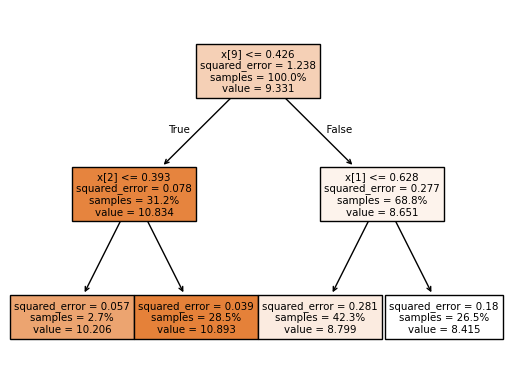

In [26]:
model = tree.ExtraTreeRegressor(max_depth=2,random_state=RANDOM_STATE)
model.fit(X_train, y_train)
tree.plot_tree(model, proportion=True, filled=True)
plt.show()

## Ансамбли

Ансамбли - это мощный инструмент из арсенала ML специалиста и поэтому будет не простительным не уделить ему отдельное внимание.

In [27]:
from sklearn import ensemble

Ансамбли разделяются на 3 вида. Далее мы разберём каждый вид.

#### Бэггинг(паралельное обучени)

Идея бэггинга заключается в обучении множества моделей на разных подвыборках данных и усреднении их предсказаний. Пример такого алгоритма это *Random Forest* 

Давайте сразу рассмотрим реализацию случайного леса на наших данных.

In [28]:
EN_TREE_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=RANDOM_STATE)
EN_TREE_RandomForestRegressor.fit(X_train, y_train)
y_pred = EN_TREE_RandomForestRegressor.predict(X_test)

history_models.add_model(EN_TREE_RandomForestRegressor, "ensemble_bagging", EN_TREE_RandomForestRegressor.get_params(), "Случайный лес", y_true=y_test, y_pred=y_pred)

c:\Users\sinde\OneDrive\Рабочий стол\classic_ml_skills\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Так же мы можем использовать линейные модели. Давайте возьмём линейную модель и ```BaggingRegressor()```. Этот класс(```BaggingRegressor()```) позволит нам использвать бэггинг с любой базовой моделью(деревья, линейные модели)

In [29]:
from sklearn import linear_model

EN_PLR_standart = ensemble.BaggingRegressor(
    estimator=linear_model.LinearRegression(),
    n_estimators=10,
    bootstrap=True
)
EN_PLR_standart.fit(X_train, y_train)
y_pred = EN_PLR_standart.predict(X_test)

history_models.add_model(EN_PLR_standart, "ensemble_bagging", EN_PLR_standart.get_params(), "Бэггинг + линейная регрессия", y_true=y_test, y_pred=y_pred)

c:\Users\sinde\OneDrive\Рабочий стол\classic_ml_skills\.venv\Lib\site-packages\sklearn\ensemble\_bagging.py:583: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Мы можем брать любую модель для бэггинга, выше представлен пример.

In [30]:
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Дерево принятия решений,0.0573,0.0233,0.1525,0.9812,0.0063,0.0002,0.0153
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Рандомные деревья,0.0664,0.0287,0.1693,0.9768,0.0073,0.0003,0.0171
2,RandomForestRegressor,ensemble_bagging,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",Случайный лес,0.0548,0.0146,0.1209,0.9882,0.0060,0.0001,0.0122
3,BaggingRegressor,ensemble_bagging,"{'bootstrap': True, 'bootstrap_features': Fals...",Бэггинг + линейная регрессия,0.2531,0.1038,0.3222,0.9160,0.0278,0.0010,0.0323


#### Стекинг(комбинирование предсказаний)

Стекинг позволяет нам комбинировать несколько моделей с помощью единой мета-модели.


---
```
модель_1 -> результат_1 - - \

модель_2 -> результат_2 - - -> мета_модель -> итоговое_предсказание

модель_3 -> результат_3 - - /
```
---


Мы обучаем модели предсказывать результат и на основе предсказаний обучаем мета-модель предсказывать итоговый результат

Давайте соберём пример такого ансамбля

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

base_estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, max_features=0.5, random_state=RANDOM_STATE)),
    ('dt', DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE)),
]

# мета моделью выберем линейную регрессию 
meta_model = LinearRegression()

# создадим стэкинг
stacking_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=3,  # поставим 3 фолда для кросс валидации
)

stacking_reg.fit(X_train, y_train)
y_pred = stacking_reg.predict(X_test)

c:\Users\sinde\OneDrive\Рабочий стол\classic_ml_skills\.venv\Lib\site-packages\sklearn\ensemble\_stacking.py:1041: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
history_models.add_model(stacking_reg, "ensemble_stacking", stacking_reg.get_params(), "стэкинг", y_true=y_test, y_pred=y_pred)

In [33]:
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Дерево принятия решений,0.0573,0.0233,0.1525,0.9812,0.0063,0.0002,0.0153
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Рандомные деревья,0.0664,0.0287,0.1693,0.9768,0.0073,0.0003,0.0171
2,RandomForestRegressor,ensemble_bagging,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",Случайный лес,0.0548,0.0146,0.1209,0.9882,0.0060,0.0001,0.0122
3,BaggingRegressor,ensemble_bagging,"{'bootstrap': True, 'bootstrap_features': Fals...",Бэггинг + линейная регрессия,0.2531,0.1038,0.3222,0.9160,0.0278,0.0010,0.0323
4,StackingRegressor,ensemble_stacking,"{'cv': 3, 'estimators': [('rf', RandomForestRe...",стэкинг,0.0610,0.0166,0.1287,0.9866,0.0067,0.0002,0.0130


#### Бустинг(последовательное улучшение)

Бустинг - последовательно обучает модели, где каждая следующая модель исправляет ошибки предыдущих, фокусируясь на плохо предсказанных примерах. Итоговое предсказание формируется путем взвешенного объединения всех моделей.

Схема работы бустинга

---

```
Данные -> Модель_1 -> Ошибки_1 ->

Модель_2 -> Ошибки_2 -> 

... 

-> Модель_N -> Итоговое_предсказание
```
---

Из преимуществ этого метода по сравнению с бэггингом и одиночными моделями хочется сразу же отметить высокую точность, так же хорошо работает с несбалансированными данными. А вот минусы - это чувствительность к шуму в данных и требует больше времени на обучение


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3, 
    subsample=0.5, 
    random_state=RANDOM_STATE
)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

c:\Users\sinde\OneDrive\Рабочий стол\classic_ml_skills\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [35]:
history_models.add_model(gbr, "ensemble_gradient", gbr.get_params(), "градиентный бустинг", y_true=y_test, y_pred=y_pred)

## Итог

In [36]:
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,DecisionTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Дерево принятия решений,0.0573,0.0233,0.1525,0.9812,0.0063,0.0002,0.0153
1,ExtraTreeRegressor,tree_model,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",Рандомные деревья,0.0664,0.0287,0.1693,0.9768,0.0073,0.0003,0.0171
2,RandomForestRegressor,ensemble_bagging,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",Случайный лес,0.0548,0.0146,0.1209,0.9882,0.0060,0.0001,0.0122
3,BaggingRegressor,ensemble_bagging,"{'bootstrap': True, 'bootstrap_features': Fals...",Бэггинг + линейная регрессия,0.2531,0.1038,0.3222,0.9160,0.0278,0.0010,0.0323
4,StackingRegressor,ensemble_stacking,"{'cv': 3, 'estimators': [('rf', RandomForestRe...",стэкинг,0.0610,0.0166,0.1287,0.9866,0.0067,0.0002,0.0130
5,GradientBoostingRegressor,ensemble_gradient,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",градиентный бустинг,0.1385,0.0378,0.1943,0.9694,0.0153,0.0004,0.0196


Подведём итог работы с деревьями и ансамблевыми методами:
* Бэггинг с линейной регрессией показал наихудший результат (R² = 0.9160), что опять же указываен на не линейность данных;
* Все древовидные модели значительно превзошли линейные подходы;

Деревья мы разобрали, линейные модели тоже разобрали, что мы будем делать далее?
Мы перейдём к методам оптимизации гиперпараметров.

In [37]:
history_models.to_new_csv("tree_models.csv")